### 카메라 포지션 최적화

In [167]:
# 1. .obj 파일 로드
# 2. Camera, Shader, Renderer 초기화
# 3. mesh render
# 4. loss function, optimizer의 반복문으로 최적화 세팅

In [168]:
## pytorch 3d install 과정
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [169]:
## import 구문
import os
import torch
import numpy as np
## 진행률 도구
from tqdm.notebook import tqdm
import imageio
## 뉴런 네트워크 도구
import torch.nn as nn
import torch.nn.functional as F
## 데이터 시각화 도구
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

## io utils
from pytorch3d.io import load_obj

## data structures
from pytorch3d.structures import Meshes

## 3D transformation functions
from pytorch3d.transforms import Rotate, Translate

## rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras,  # (  ) 카메라의 시야각을 예상해주는 도구
    look_at_view_transform, # (  ) 회전 및 변환 행렬을 반환하여 월드 좌표에서 뷰 좌표[0]로 Look At 변환
    look_at_rotation,       # ( camera_position, at, up ) Camera 의 벡터값, at은 글로벌 좌표에서의 물체의 위치, up: 글로벌 좌표에서 위쪽 방향을 지정
    RasterizationSettings,  # (  ) 레스터화는 3D 모델을 렌더링 하는 일반적인 기술
    MeshRenderer,           #
    MeshRasterizer,         #
    BlendParams,            # ( sigma, gamma, background_color ) sigma: 사용되는 시그모이드 함수의 너비를 제어, gamma: 사용되는 지수함수의 배율을 제어, background_color: 배경색에 대한 튜플 제공
    SoftSilhouetteShader,   #
    HardPhongShader,        #
    PointLights,            #
    TexturesVertex          #
)

In [170]:
## 데이터 다운로드
!mkdir -p data
!wget -P data https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2022-09-29 18:25:04--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: 'data/teapot.obj.1'

teapot.obj.1        100%[===================>] 149.02K   465KB/s    in 0.3s    

2022-09-29 18:25:06 (465 KB/s) - 'data/teapot.obj.1' saved [152595/152595]



In [171]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# 오브젝트 데이터 로드
verts, faces_idx, _ = load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

In [172]:
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features = verts_rgb.to(device))
print(verts.size())
print(verts_rgb.size())

teapot_mesh = Meshes(
    verts = [ verts.to(device) ], # 정점 데이터 입력
    faces = [ faces.to(device) ], # 면 데이터 입력
    textures = textures           # ??
)

torch.Size([1292, 3])
torch.Size([1, 1292, 3])


In [173]:
# 카메라 초기화
cameras = FoVPerspectiveCameras(device=device)
#
blend_params = BlendParams(sigma = 1e-4, gamma=1e-4)

# 이미지는 픽셀의 배열로 이루어진다
raster_settings = RasterizationSettings(                         #
    image_size = 256,                                            # 이미지의 사이즈 결정
    blur_radius = np.log(1.0 / 1e-4 - 1.0) * blend_params.sigma, # 면적을 확장하는데 사용되는 0 ~ 2 플로트 범위
    faces_per_pixel = 100                                        # 픽셀 당 추적할 면적 수
)

# Mesh 렌더러
## rasterization: 물체의 표현을 위해 픽셀을 결정하는 작업
## shader:
silhouette_renderer = MeshRenderer(
    # raster(래스터)란 pixel(화소)을 의미
    # rasterization(래스터화)이란, 물체 표현을 위해 어떤 화소를 밝힐지 결정하는 작업
    rasterizer = MeshRasterizer(
        cameras = cameras,
        raster_settings = raster_settings # 래스터화 (RasterizationSettings)에 대한 매개 변수
    ),

    # shader: 3D 컴퓨터 그래픽에서 최종적으로 화면에 출력하는 픽셀의 색을 정해주는 함수
    shader = SoftSilhouetteShader(blend_params=blend_params)
)

# 조명의 위치 설정 ?
lights = PointLights(
    device = device,
    location = (( 2.0, 2.0, -2.0 ),)  # 빛의 x, y ,z 위치
)


phong_renderer = MeshRenderer(
    rasterizer = MeshRasterizer(
        cameras = cameras,
        raster_settings = raster_settings
    ),
    shader = HardPhongShader(
        device = device,
        cameras = cameras,
        lights = lights
    )
)

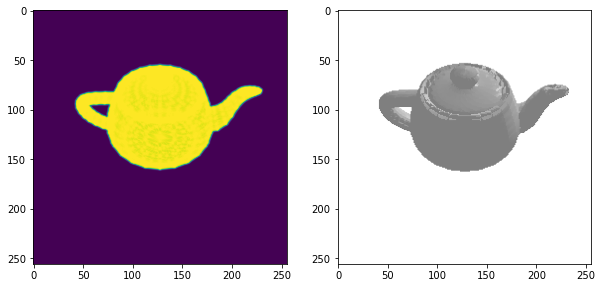

In [174]:
R, T = look_at_view_transform(
    dist = 3,    # 물체와 카메라의 거리
    elev = 50.0, # 물체에서 카메라 까지의 라디안 각도, 객체에서 카메라 까지의 벡터와 Y수평면 사이각
    azim = 0.0   # 물체에서 카메라 까지의 라디안 각도, 객체에서 카메라 까지의 벡터가 Y수평면에 투영된 벡터와 Y평면 사이의 각도
)
#
silhouette = silhouette_renderer(meshes_world = teapot_mesh, R = R, T = T)
image_ref = phong_renderer(meshes_world = teapot_mesh, R = R, T = T)

#
silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)                      #
plt.imshow(silhouette.squeeze()[ ..., 3]) #
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

In [175]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)

        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([ 3.0, 6.9, +2.5 ], dtype = np.float32)).to(meshes.device)
        )

    def forward(self):
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)

        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image

In [176]:
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode = "I", duration = 0.3)

model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

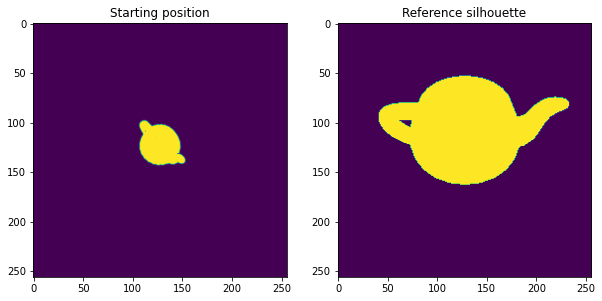

In [177]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

  0%|          | 0/200 [00:00<?, ?it/s]

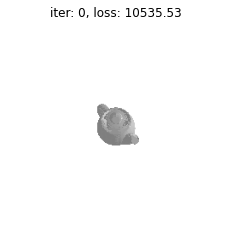

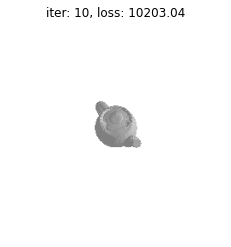

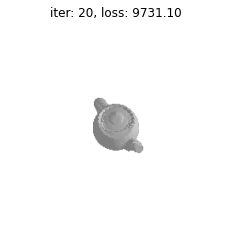

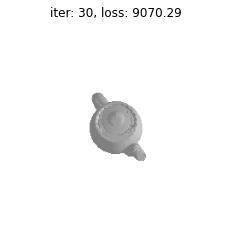

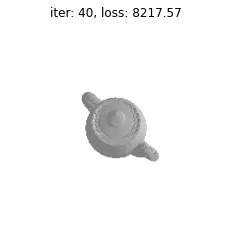

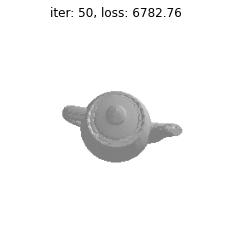

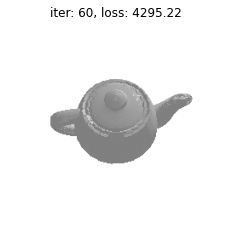

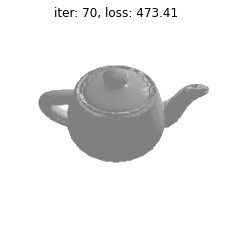

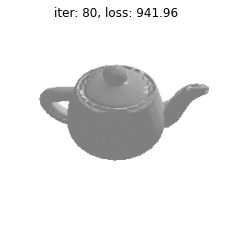

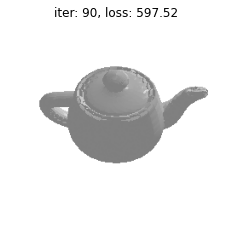

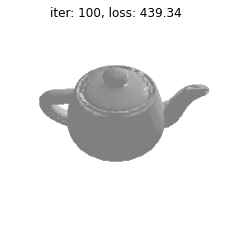

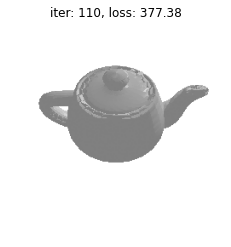

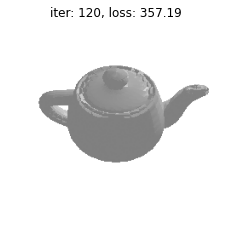

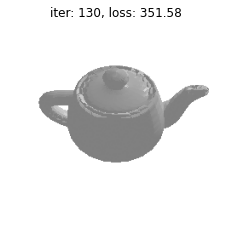

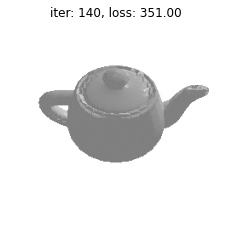

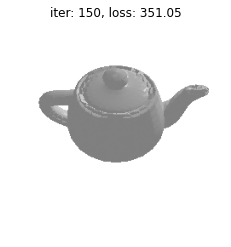

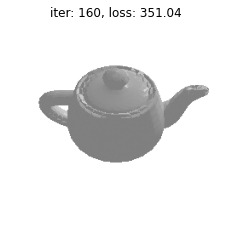

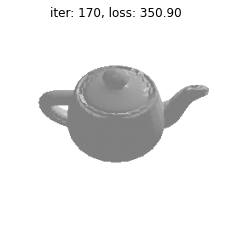

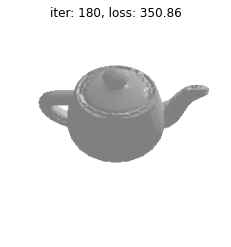

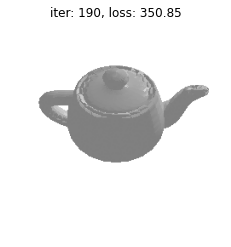

In [178]:
loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if loss.item() < 200:
        break

    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")

writer.close()